<a href="https://colab.research.google.com/github/Adeelzafar/My-Version-of-Fastai-Course/blob/main/BlueBook_Kaggle_RandomForest_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
! pip install kaggle

In [3]:
!pip install -Uqq fastbook
import fastbook   
fastbook.setup_book()

     |████████████████████████████████| 720 kB 5.3 MB/s 
     |████████████████████████████████| 186 kB 48.9 MB/s 
     |████████████████████████████████| 1.2 MB 26.9 MB/s 
     |████████████████████████████████| 46 kB 4.0 MB/s 
     |████████████████████████████████| 56 kB 3.8 MB/s 
     |████████████████████████████████| 51 kB 215 kB/s 
Mounted at /content/gdrive


In [10]:
creds = '{"username":"adizafar","key":"ea7f2619db0547e5aeea6d49d5b76209"}'

In [11]:
cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(creds)
    cred_path.chmod(0o600)

In [13]:
from fastbook import *
from kaggle import api
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

In [17]:
path = URLs.path('bluebook')
path

Path('/root/.fastai/archive/bluebook')

In [ ]:
#Path.BASE_PATH = path

In [21]:
#kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge

In [35]:
if not path.exists():
    path.mkdir(parents=true)
    #api.dataset_download_files('bluebook-for-bulldozers') 
    api.competition_download_cli('bluebook-for-bulldozers', path=path)
    file_extract(path/'bluebook-for-bulldozers.zip')
    
path.ls()

(#1) [Path('/root/.fastai/archive/bluebook/bluebook-for-bulldozers.zip')]

In [36]:
path.ls(file_type='text')

(#0) []

In [40]:
npath = '/content/gdrive/MyDrive/fastai-v3/data/bluebook-for-bulldozers/TrainAndValid.csv.zip'
df = pd.read_csv(npath, low_memory=False)

In [41]:
df

,SalesID,SalePrice,MachineID,ModelID,...,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,...,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,...,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,...,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,...,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,...,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
412693,6333344,10000.0,1919201,21435,...,NaN,NaN,NaN,NaN
412694,6333345,10500.0,1882122,21436,...,NaN,NaN,NaN,NaN
412695,6333347,12500.0,1944213,21435,...,NaN,NaN,NaN,NaN
412696,6333348,10000.0,1794518,21435,...,NaN,NaN,NaN,NaN


In [42]:
df.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'saledate', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc',
       'fiModelSeries', 'fiModelDescriptor', 'ProductSize',
       'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc',
       'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control',
       'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension',
       'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics',
       'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size',
       'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow',
       'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb',
       'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type',
       'Travel_Controls', 'Differential_Type', 'Steering_Controls'],
      dtype='object')

In [43]:
df['ProductSize'].unique()

array([nan, 'Medium', 'Small', 'Large / Medium', 'Mini', 'Large', 'Compact'], dtype=object)

In [44]:
sizes = 'Large','Large / Medium','Medium','Small','Mini','Compact'

In [45]:
df['ProductSize'] = df['ProductSize'].astype('category')

In [46]:
dep_var = 'SalePrice'

In [47]:
df[dep_var] = np.log(df[dep_var])

In [48]:
df = add_datepart(df, 'saledate')

In [51]:
testpath = '/content/gdrive/MyDrive/fastai-v3/data/bluebook-for-bulldozers/Test.csv.zip'

df_test = pd.read_csv(testpath, low_memory=False)
df_test = add_datepart(df_test, 'saledate')

In [52]:
' '.join(o for o in df.columns if o.startswith('sale'))

'saleYear saleMonth saleWeek saleDay saleDayofweek saleDayofyear saleIs_month_end saleIs_month_start saleIs_quarter_end saleIs_quarter_start saleIs_year_end saleIs_year_start saleElapsed'

In [53]:
procs = [Categorify, FillMissing]

In [54]:
cond = (df.saleYear<2011) | (df.saleMonth<10)
train_idx = np.where( cond)[0]
valid_idx = np.where(~cond)[0]

splits = (list(train_idx),list(valid_idx))

In [55]:
cont,cat = cont_cat_split(df, 1, dep_var=dep_var)

In [56]:
to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)

In [57]:
len(to.train),len(to.valid)

(404710, 7988)

In [58]:
to.show(3)

,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,auctioneerID_na,MachineHoursCurrentMeter_na,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,saleYear,saleMonth,saleWeek,saleDay,saleDayofweek,saleDayofyear,saleElapsed,SalePrice
0,Low,521D,521,D,#na#,#na#,#na#,Wheel Loader - 110.0 to 120.0 Horsepower,Alabama,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,False,False,1139246,999089,3157,121,3.0,2004,68.0,2006,11,46,16,3,320,1.163635e+09,11.097410
1,Low,950FII,950,F,II,#na#,Medium,Wheel Loader - 150.0 to 175.0 Horsepower,North Carolina,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,23.5,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,False,False,1139248,117657,77,121,3.0,1996,4640.0,2004,3,13,26,4,86,1.080259e+09,10.950807
2,High,226,226,#na#,#na#,#na#,#na#,Skid Steer Loader - 1351.0 to 1601.0 Lb Operating Capacity,New York,SSL,Skid Steer Loaders,#na#,OROPS,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Auxiliary,#na#,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,None or Unspecified,Standard,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,False,False,False,False,False,False,False,False,1139249,434808,7009,121,3.0,2001,2838.0,2004,2,9,26,3,57,1.077754e+09,9.210340


In [59]:
to1 = TabularPandas(df, procs, ['state', 'ProductGroup', 'Drive_System', 'Enclosure'], [], y_names=dep_var, splits=splits)
to1.show(3)

,state,ProductGroup,Drive_System,Enclosure,SalePrice
0,Alabama,WL,#na#,EROPS w AC,11.097410
1,North Carolina,WL,#na#,EROPS w AC,10.950807
2,New York,SSL,#na#,OROPS,9.210340


In [60]:
to.items.head(3)

,SalesID,SalePrice,MachineID,ModelID,...,saleIs_year_start,saleElapsed,auctioneerID_na,MachineHoursCurrentMeter_na
0,1139246,11.097410,999089,3157,...,1,1.163635e+09,1,1
1,1139248,10.950807,117657,77,...,1,1.080259e+09,1,1
2,1139249,9.210340,434808,7009,...,1,1.077754e+09,1,1


In [61]:
to1.items[['state', 'ProductGroup', 'Drive_System', 'Enclosure']].head(3)

,state,ProductGroup,Drive_System,Enclosure
0,1,6,0,3
1,33,6,0,3
2,32,3,0,6


In [62]:
to.classes['ProductSize']

['#na#', 'Compact', 'Large', 'Large / Medium', 'Medium', 'Mini', 'Small']

In [63]:
save_pickle(path/'to.pkl',to)

In [64]:
to = load_pickle(path/'to.pkl')

In [65]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

In [66]:
m = DecisionTreeRegressor(max_leaf_nodes=4)
m.fit(xs, y);

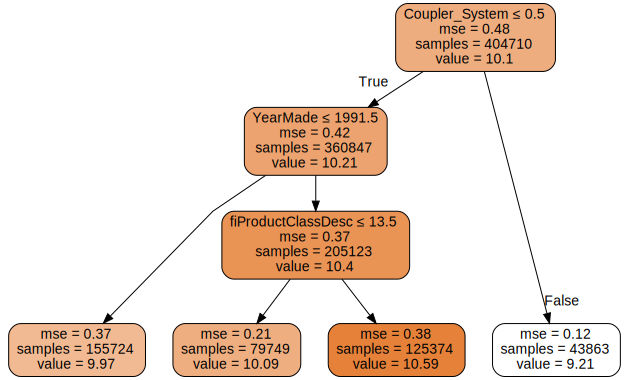

In [67]:
draw_tree(m, xs, size=10, leaves_parallel=True, precision=2)

In [69]:
pip install dtreeviz             # install dtreeviz for sklearn

     |████████████████████████████████| 61 kB 452 kB/s 
  Created wheel for dtreeviz: filename=dtreeviz-1.3.1-py3-none-any.whl size=67694 sha256=268a53820779418b3351e253b68c07f53a8a4e380de51300fa7eaa4d88c2225e
  Stored in directory: /root/.cache/pip/wheels/f4/e0/4c/26144f03fd05b7c3d82e5cf2679c2d6bd9d9b730548264674d
Successfully built dtreeviz


In [70]:
from dtreeviz.trees import *

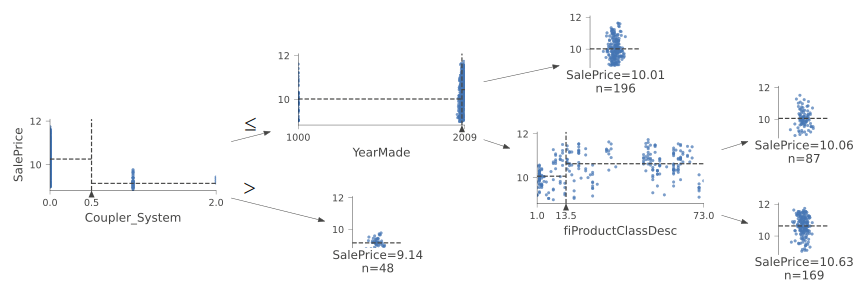

In [71]:
samp_idx = np.random.permutation(len(y))[:500]
dtreeviz(m, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, dep_var,
        fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
        orientation='LR')

In [72]:
xs.loc[xs['YearMade']<1900, 'YearMade'] = 1950
valid_xs.loc[valid_xs['YearMade']<1900, 'YearMade'] = 1950

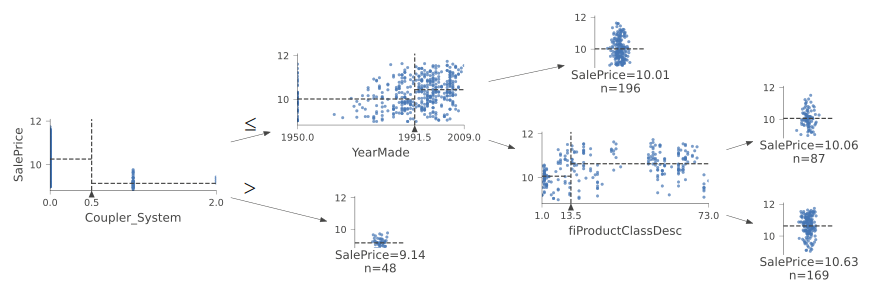

In [73]:
m = DecisionTreeRegressor(max_leaf_nodes=4).fit(xs, y)

dtreeviz(m, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, dep_var,
        fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
        orientation='LR')

In [74]:
m = DecisionTreeRegressor()
m.fit(xs, y);

In [75]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [76]:
m_rmse(m, xs, y)

1e-06

In [77]:
m_rmse(m, valid_xs, valid_y)

0.330762

In [78]:
m.get_n_leaves(), len(xs)

(324346, 404710)

In [80]:
m.get_n_leaves()

324346

In [81]:
def rf(xs, y, n_estimators=40, max_samples=200_000,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [82]:
m = rf(xs, y);

In [83]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.171307, 0.23441)

In [84]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

In [85]:
r_mse(preds.mean(0), valid_y)

0.23441

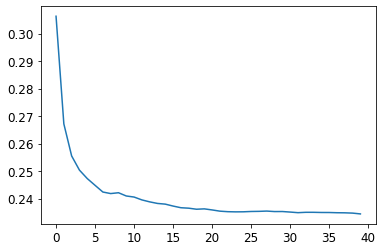

In [86]:
plt.plot([r_mse(preds[:i+1].mean(0), valid_y) for i in range(40)]);

In [87]:
r_mse(m.oob_prediction_, y)

0.211235

In [88]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [89]:
fi = rf_feat_importance(m, xs)
fi[:10]

,cols,imp
57,YearMade,0.170658
30,Coupler_System,0.107711
6,ProductSize,0.106080
7,fiProductClassDesc,0.081614
54,ModelID,0.056093
32,Hydraulics_Flow,0.050735
65,saleElapsed,0.049995
3,fiSecondaryDesc,0.048736
31,Grouser_Tracks,0.037344
12,Enclosure,0.034935


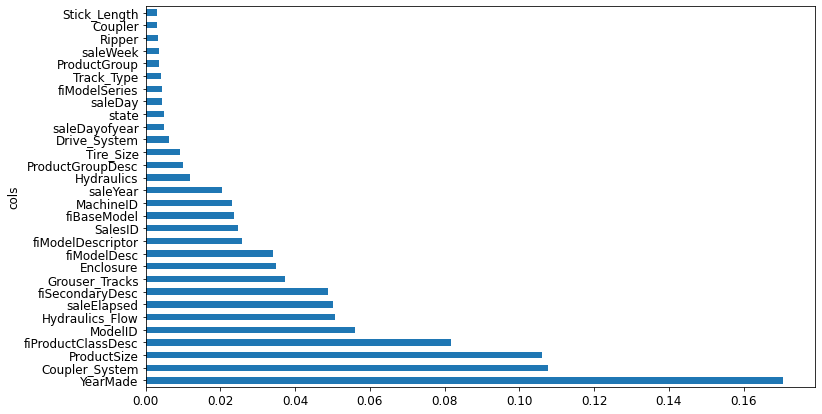

In [90]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:30]);

In [91]:
to_keep = fi[fi.imp>0.005].cols
len(to_keep)

20

In [92]:
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

In [93]:
m = rf(xs_imp, y)

In [94]:
m_rmse(m, xs_imp, y), m_rmse(m, valid_xs_imp, valid_y)

(0.181107, 0.230312)

In [95]:
len(xs.columns), len(xs_imp.columns)

(66, 20)

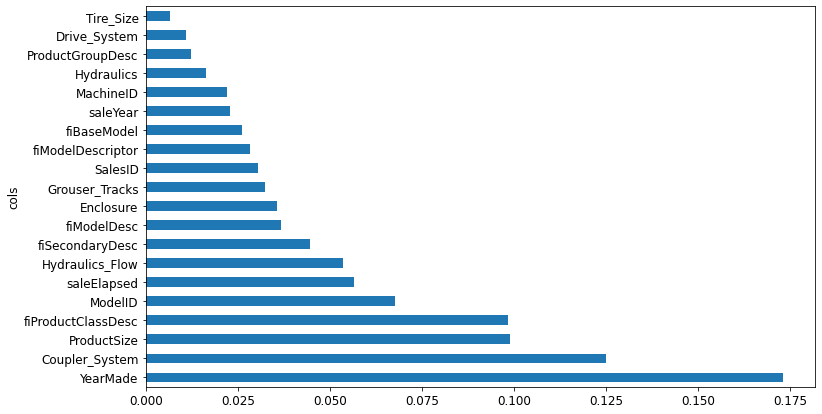

In [96]:
plot_fi(rf_feat_importance(m, xs_imp));

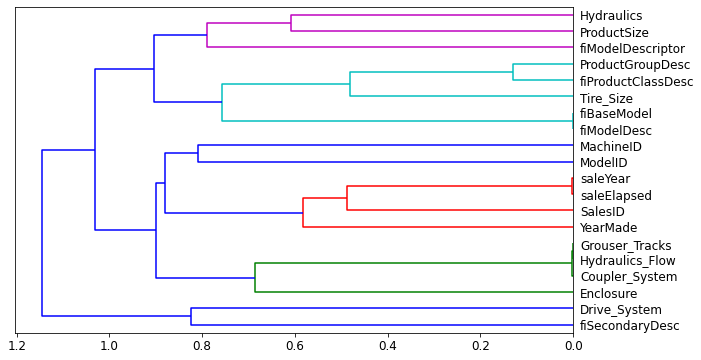

In [97]:
cluster_columns(xs_imp)

In [98]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=15,
        max_samples=50000, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(df, y)
    return m.oob_score_

In [99]:
get_oob(xs_imp)

0.8761157355562238

In [101]:
{c:get_oob(xs_imp.drop(c, axis=1)) for c in (
    'saleYear', 'saleElapsed', 'ProductGroupDesc',
    'fiModelDesc', 'fiBaseModel',
    'Hydraulics_Flow','Grouser_Tracks', 'Coupler_System')}

{'Coupler_System': 0.8763845409599874,
 'Grouser_Tracks': 0.8752053779423208,
 'Hydraulics_Flow': 0.8755292739180696,
 'ProductGroupDesc': 0.8756640163954027,
 'fiBaseModel': 0.8750813646274371,
 'fiModelDesc': 0.8739455939162314,
 'saleElapsed': 0.8708039915004109,
 'saleYear': 0.8746684674567902}

In [103]:
to_drop = ['saleYear', 'ProductGroupDesc', 'fiBaseModel', 'Grouser_Tracks']
get_oob(xs_imp.drop(to_drop, axis=1))

0.8739523856443225

In [104]:
xs_final = xs_imp.drop(to_drop, axis=1)
valid_xs_final = valid_xs_imp.drop(to_drop, axis=1)

In [105]:
save_pickle(path/'xs_final.pkl', xs_final)
save_pickle(path/'valid_xs_final.pkl', valid_xs_final)

In [106]:
xs_final = load_pickle(path/'xs_final.pkl')
valid_xs_final = load_pickle(path/'valid_xs_final.pkl')

In [107]:
m = rf(xs_final, y)
m_rmse(m, xs_final, y), m_rmse(m, valid_xs_final, valid_y)

(0.182713, 0.232217)

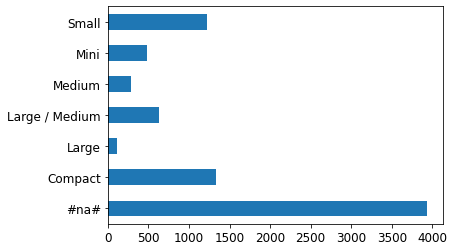

In [108]:
p = valid_xs_final['ProductSize'].value_counts(sort=False).plot.barh()
c = to.classes['ProductSize']
plt.yticks(range(len(c)), c);

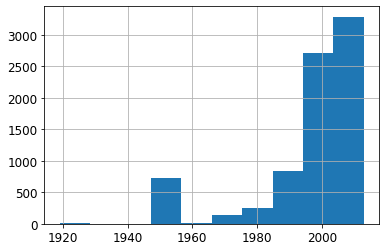

In [109]:
ax = valid_xs_final['YearMade'].hist()

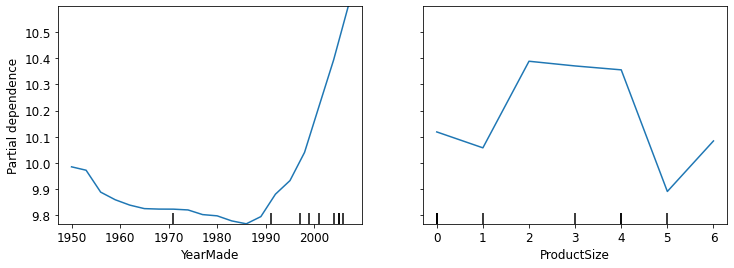

In [110]:
from sklearn.inspection import plot_partial_dependence

fig,ax = plt.subplots(figsize=(12, 4))
plot_partial_dependence(m, valid_xs_final, ['YearMade','ProductSize'],
                        grid_resolution=20, ax=ax);



In [111]:
np.random.seed(42)

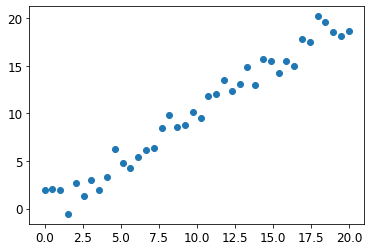

In [112]:
x_lin = torch.linspace(0,20, steps=40)
y_lin = x_lin + torch.randn_like(x_lin)
plt.scatter(x_lin, y_lin);

In [113]:
xs_lin = x_lin.unsqueeze(1)
x_lin.shape,xs_lin.shape

(torch.Size([40]), torch.Size([40, 1]))

In [114]:
x_lin[:,None].shape

torch.Size([40, 1])

In [115]:
m_lin = RandomForestRegressor().fit(xs_lin[:30],y_lin[:30])

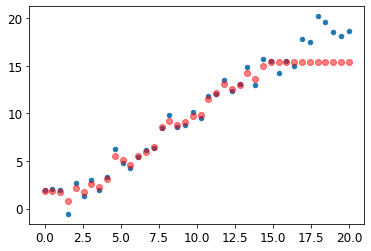

In [116]:
plt.scatter(x_lin, y_lin, 20)
plt.scatter(x_lin, m_lin.predict(xs_lin), color='red', alpha=0.5);

In [117]:
df_dom = pd.concat([xs_final, valid_xs_final])
is_valid = np.array([0]*len(xs_final) + [1]*len(valid_xs_final))

m = rf(df_dom, is_valid)
rf_feat_importance(m, df_dom)[:6]

,cols,imp
6,saleElapsed,0.903666
11,SalesID,0.068720
12,MachineID,0.024188
0,YearMade,0.001247
9,fiModelDesc,0.000459
14,Tire_Size,0.000364


In [118]:
m = rf(xs_final, y)
print('orig', m_rmse(m, valid_xs_final, valid_y))

for c in ('SalesID','saleElapsed','MachineID'):
    m = rf(xs_final.drop(c,axis=1), y)
    print(c, m_rmse(m, valid_xs_final.drop(c,axis=1), valid_y))

orig 0.233297
SalesID 0.230378
saleElapsed 0.236299
MachineID 0.230612


In [119]:
time_vars = ['SalesID','MachineID']
xs_final_time = xs_final.drop(time_vars, axis=1)
valid_xs_time = valid_xs_final.drop(time_vars, axis=1)

m = rf(xs_final_time, y)
m_rmse(m, valid_xs_time, valid_y)

0.229159

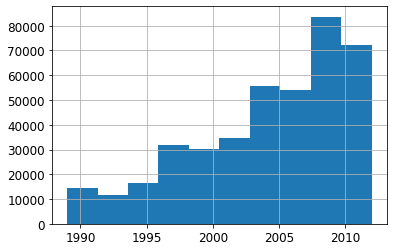

In [120]:
xs['saleYear'].hist();

In [121]:
filt = xs['saleYear']>2004
xs_filt = xs_final_time[filt]
y_filt = y[filt]

In [122]:
m = rf(xs_filt, y_filt)
m_rmse(m, xs_filt, y_filt), m_rmse(m, valid_xs_time, valid_y)

(0.17658, 0.228456)

In [124]:
df_nn = pd.read_csv(npath, low_memory=False)
df_nn['ProductSize'] = df_nn['ProductSize'].astype('category')
df_nn['ProductSize'].cat.set_categories(sizes, ordered=True, inplace=True)
df_nn[dep_var] = np.log(df_nn[dep_var])
df_nn = add_datepart(df_nn, 'saledate')

In [125]:
df_nn_final = df_nn[list(xs_final_time.columns) + [dep_var]]

In [126]:
cont_nn,cat_nn = cont_cat_split(df_nn_final, max_card=9000, dep_var=dep_var)

In [127]:
cont_nn

['saleElapsed']

In [128]:
df_nn_final[cat_nn].nunique()

YearMade                73
Coupler_System           2
ProductSize              6
fiProductClassDesc      74
ModelID               5281
Hydraulics_Flow          3
fiSecondaryDesc        177
Enclosure                6
fiModelDesc           5059
fiModelDescriptor      140
Hydraulics              12
Tire_Size               17
Drive_System             4
dtype: int64

In [129]:
xs_filt2 = xs_filt.drop('fiModelDescriptor', axis=1)
valid_xs_time2 = valid_xs_time.drop('fiModelDescriptor', axis=1)
m2 = rf(xs_filt2, y_filt)
m_rmse(m2, xs_filt2, y_filt), m_rmse(m2, valid_xs_time2, valid_y)

(0.178918, 0.230683)

In [130]:
cat_nn.remove('fiModelDescriptor')

In [131]:
procs_nn = [Categorify, FillMissing, Normalize]
to_nn = TabularPandas(df_nn_final, procs_nn, cat_nn, cont_nn,
                      splits=splits, y_names=dep_var)

In [132]:
dls = to_nn.dataloaders(1024)

In [133]:
y = to_nn.train.y
y.min(),y.max()

(8.465899467468262, 11.863582611083984)

In [134]:
learn = tabular_learner(dls, y_range=(8,12), layers=[500,250],
                        n_out=1, loss_func=F.mse_loss)

SuggestedLRs(valley=0.00019054606673307717)

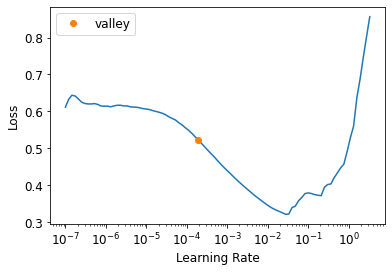

In [135]:
learn.lr_find()

In [136]:
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,time
0,0.061989,0.061996,00:07
1,0.053725,0.055059,00:07
2,0.047306,0.062700,00:07
3,0.043272,0.051015,00:07
4,0.040203,0.050359,00:07


In [137]:
preds,targs = learn.get_preds()
r_mse(preds,targs)

0.224408

In [138]:
learn.save('nn')

Path('models/nn.pth')

In [139]:
rf_preds = m.predict(valid_xs_time)
ens_preds = (to_np(preds.squeeze()) + rf_preds) /2

In [140]:
r_mse(ens_preds,valid_y)

0.221507